In [ ]:
# Machine learning
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# For data manipulation
import pandas as pd
import numpy as np

# To plot
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Read the csv file using read_csv
# method of pandas
df = pd.read_csv('ADANI.csv')
df
df = df.interpolate(method='linear')
df.isna().sum()


In [ ]:
# Changes The Date column as index columns
df.index = pd.to_datetime(df['Date'])
df

# drop The original date column
df = df.drop(['Date'], axis='columns')
df


In [ ]:
# Create predictor variables
df['Open-Close'] = df.Open - df.Close
df['High-Low'] = df.High - df.Low
  
# Store all predictor variables in a variable X
X = df[['Open-Close', 'High-Low']]
X.head()

# Target variables
y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
y


In [ ]:
from sklearn.metrics import confusion_matrix

split_percentage = 0.8
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
y_train = y[:split]

# Test data set
X_test = X[split:]
y_test = y[split:]

# Support vector classifier
# cls = SVC().fit(X_train, y_train)
# cls = SVC(kernel='sigmoid').fit(X_train, y_train)
cls = SVC(kernel='poly').fit(X_train, y_train)

y_pred = cls.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print(f"Accuracy: {accuracy:.2f}")

In [ ]:
df['Predicted_Signal'] = cls.predict(X)
# Calculate daily returns
df['Return'] = df.Close.pct_change()
# Calculate strategy returns
df['Strategy_Return'] = df.Return *df.Predicted_Signal.shift(1)
# Calculate Cumulutive returns
df['Cum_Ret'] = df['Return'].cumsum()
df
# Plot Strategy Cumulative returns
df['Cum_Strategy'] = df['Strategy_Return'].cumsum()
df


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df['Cum_Ret'],color='red',label = 'actual cumulative returns')
plt.plot(df['Cum_Strategy'],color='blue',label = 'strategy cumulative returns')

plt.legend()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

# Load the stock price data
data = pd.read_csv('ADANI.csv')

# Extract the 'Close' column for prediction
closing_prices = data['Close'].values

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences and labels for training
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)



# Scale the predictions back to the original range
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()


# Plot the predicted vs actual prices
plt.plot(closing_prices, color='blue', label='Actual Prices')
plt.plot(np.concatenate([train_predictions, test_predictions]), color='red', label='Predicted Prices')
plt.legend()
plt.show()


In [ ]:
!pip install tensorflow


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.regularizers import L2
from sklearn.model_selection import cross_val_score


# Load the stock price data
data = pd.read_csv('ADANI.csv')
data = data.interpolate(method='linear')

# Extract the 'Close' column for prediction
closing_prices = data['Close'].values

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.9)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences and labels for training
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)



# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, kernel_regularizer=L2(0.01)))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean score
mean_score = np.mean(scores)
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

#Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Scale the predictions back to the original range
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate profits based on a simple trading strategy
buy_threshold = 0.02  # Percentage increase threshold to buy
sell_threshold = -0.01  # Percentage decrease threshold to sell
initial_investment = 10000  # Initial investment amount
shares = 0
cash = initial_investment

for i in range(len(test_predictions)):
    price_change = (y_test[i] - y_test[i-1]) / y_test[i-1]  # Percentage price change from the previous day
    
    if price_change > buy_threshold:
        shares_to_buy = cash / y_test[i]
        shares += shares_to_buy
        cash = 0
    elif price_change < sell_threshold:
        cash_to_sell = shares * y_test[i]
        cash += cash_to_sell
        shares = 0

final_balance = cash + (shares * y_test[-1])
profit = final_balance - initial_investment

# Print the metrics and profit
# print("Training MAE:", train_mae)
# print("Testing MAE:", test_mae)
# print("Training MSE:", train_mse)
# print("Testing MSE:", test_mse)
# print("Training RMSE:", train_rmse)
# print("Testing RMSE:", test_rmse)
print("Profit:", profit)


# Plot transactions for RNN
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_predictions, label='Predicted Price', color='orange')
plt.title('Stock Price Prediction - RNN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate daily returns for RNN

daily_returns_rnn = np.diff(y_test) / y_test[:-1]

# Plot returns for RNN
plt.figure(figsize=(12, 6))
plt.plot(daily_returns_rnn, label='Daily Returns', color='green')
plt.title('Daily Returns - RNN')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the stock price data
data = pd.read_csv('ADANI.csv')
data = data.interpolate(method='linear')
# Extract the 'Close' column for prediction
closing_prices = data['Close'].values

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences and labels for training
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Flatten the input sequences
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Build the GBM model
model = GradientBoostingRegressor()

# Train the model
model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Scale the predictions back to the original range
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).ravel()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).ravel()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate profits based on a simple trading strategy
buy_threshold = 0.02  # Percentage increase threshold to buy
sell_threshold = -0.01  # Percentage decrease threshold to sell
initial_investment = 10000  # Initial investment amount
shares = 0
cash = initial_investment

for i in range(len(test_predictions)):
    price_change = (y_test[i] - y_test[i-1]) / y_test[i-1]  # Percentage price change from the previous day
    
    if price_change > buy_threshold:
        shares_to_buy = cash / y_test[i]
        shares += shares_to_buy
        cash = 0
    elif price_change < sell_threshold:
        cash_to_sell = shares * y_test[i]
        cash += cash_to_sell
        shares = 0

final_balance = cash + (shares * y_test[-1])
profit = final_balance - initial_investment

# Print the metrics and profit
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)
print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Profit:", profit)


plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_predictions, label='Predicted Price', color='orange')
plt.title('Stock Price Prediction - GBM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate daily returns for GBM
daily_returns_gbm = np.diff(y_test) / y_test[:-1]

# Plot returns for GBM
plt.figure(figsize=(12, 6))
plt.plot(daily_returns_gbm, label='Daily Returns', color='green')
plt.title('Daily Returns - GBM')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the stock price data
data = pd.read_csv('ADANI.csv')

# Extract the 'Close' column for prediction
closing_prices = data['Close'].values

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences and labels for training
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Flatten the input sequences
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Define the kernel for the GP model
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)

# Create the GP regressor
model = GaussianProcessRegressor(kernel=kernel)

# Train the GP model
model.fit(X_train, y_train)

# Make predictions
train_predictions, train_std = model.predict(X_train, return_std=True)
test_predictions, test_std = model.predict(X_test, return_std=True)

# Scale the predictions back to the original range
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1)).ravel()
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1)).ravel()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Calculate profits based on a simple trading strategy
buy_threshold = 0.02  # Percentage increase threshold to buy
sell_threshold = -0.01  # Percentage decrease threshold to sell
initial_investment = 10000  # Initial investment amount
shares = 0
cash = initial_investment

for i in range(len(test_predictions)):
    price_change = (y_test[i] - y_test[i-1]) / y_test[i-1]  # Percentage price change from the previous day
    
    if price_change > buy_threshold:
        shares_to_buy = cash / y_test[i]
        shares += shares_to_buy
        cash = 0
    elif price_change < sell_threshold:
        cash_to_sell = shares * y_test[i]
        cash += cash_to_sell
        shares = 0

final_balance = cash + (shares * y_test[-1])
profit = final_balance - initial_investment

# Print the metrics and profit
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)
print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Profit:", profit)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_predictions, label='Predicted Price', color='orange')
plt.title('Stock Price Prediction - Gaussian Processes')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate daily returns for Gaussian Processes
daily_returns_gp = np.diff(y_test) / y_test[:-1]

# Plot returns for Gaussian Processes
plt.figure(figsize=(12, 6))
plt.plot(daily_returns_gp, label='Daily Returns', color='green')
plt.title('Daily Returns - Gaussian Processes')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data from the CSV file
data = pd.read_csv('ADANI.csv')

# Extract the features and target variable
X = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Support Vector Regression model with RBF kernel
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test)






data['Predicted'] = svm_model.predict(X)

# Calculate the daily returns
data['Return'] = data['Close'].pct_change()

# Set the initial capital
initial_capital = 10000

# Buy and sell signals
data['Signal'] = 0
data.loc[data['Predicted'].shift() < data['Predicted'], 'Signal'] = 1
data.loc[data['Predicted'].shift() > data['Predicted'], 'Signal'] = -1

# Calculate position
data['Position'] = data['Signal'].shift()

# Calculate portfolio holdings and cash
data['Holdings'] = data['Position'] * data['Close']
data['Cash'] = initial_capital - (data['Position'] * data['Close']).cumsum()

# Calculate total portfolio value
data['Portfolio Value'] = data['Cash'] + data['Holdings']

# Plot the portfolio value
plt.plot(data['Portfolio Value'])
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.title('Trading Strategy Performance')
plt.show()

final_portfolio_value = data['Portfolio Value'].iloc[-1]
print(f"Final Portfolio Value: {final_portfolio_value}")




In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Load the data from the CSV file
data = pd.read_csv('ADANI.csv')

# Extract the features and target variable
X = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Support Vector Regression model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = svm_model.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Define a trading strategy using SVM predictions
def trading_strategy(prices, predictions):
    positions = []
    for i in range(len(predictions)):
        if predictions[i] > prices[i]:
            positions.append(1)  # Buy signal
        elif predictions[i] < prices[i]:
            positions.append(-1)  # Sell signal
        else:
            positions.append(0)  # No change in position
    return positions

# Apply the trading strategy
positions = trading_strategy(data['Close'][:-1], y_pred[:-1])

# Calculate daily returns based on the positions
returns = data['Close'].pct_change().shift(-1) * positions

# Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()

# Calculate the total profit
initial_capital = 100000  # Initial capital in dollars
total_profit = initial_capital * (cumulative_returns[-1] - 1)

print(f"Total Profit: {total_profit:.2f}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the stock price data
data = pd.read_csv('ADANI.csv')

# Extract the features and target variable
X = data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y = data['Close']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Backtest the trading strategy
buy_threshold = 0.02  # Percentage increase threshold to buy
sell_threshold = -0.01  # Percentage decrease threshold to sell
initial_investment = 10000  # Initial investment amount
shares = 0
cash = initial_investment
positions = []

for i in range(len(y_test)):
    price_change = (y_test.iloc[i] - y_test.iloc[i-1]) / y_test.iloc[i-1]  # Percentage price change from the previous day
    
    if price_change > buy_threshold:
        shares_to_buy = cash / y_test.iloc[i]
        shares += shares_to_buy
        cash = 0
        positions.append(1)  # Buy signal
    elif price_change < sell_threshold:
        cash_to_sell = shares * y_test.iloc[i]
        cash += cash_to_sell
        shares = 0
        positions.append(-1)  # Sell signal
    else:
        positions.append(0)  # No action

# Calculate profits based on the positions
returns = y_test.pct_change() * positions
profits = returns.sum()

print("Profits:", profits)

# Calculate the cumulative returns
cumulative_returns = (1 + returns).cumprod()




2023-06-07 02:50:04.154955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 02:50:04.156674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 02:50:04.157691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-07 02:50:04.436027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 02:50:04.437533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 02:50:04.438614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

69/69 [==============================] - 5s 13ms/step - loss: 0.0346
Epoch 2/10
69/69 [==============================] - 1s 14ms/step - loss: 0.0013
Epoch 3/10
69/69 [==============================] - 1s 15ms/step - loss: 0.0012
Epoch 4/10
69/69 [==============================] - 1s 15ms/step - loss: 0.0013
Epoch 5/10
69/69 [==============================] - 1s 14ms/step - loss: 0.0012
Epoch 6/10
69/69 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 7/10
69/69 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 8/10
69/69 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 9/10
69/69 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 10/10
69/69 [==============================] - 1s 13ms/step - loss: 0.0012


2023-06-07 02:50:17.766121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 02:50:17.768540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 02:50:17.770746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 5ms/step


2023-06-07 02:50:18.797842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-07 02:50:18.799458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-07 02:50:18.800805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 0s 7ms/step
2.341080716357508e+16
Annualized Return: 0.0378566268934812
Sharpe Ratio: 5.616798911011707
Maximum Drawdown: 0.0
Training MAE: 269.55068846102273
Testing MAE: 251.49664197587722
Training MSE: 133624.69174729456
Testing MSE: 88827.48900895829
Training RMSE: 365.5471128969487
Testing RMSE: 298.0394084831036
R2 Score: 0.4835032726247832
Sharpe Ratio: 5.616798911011707
Maximum Drawdown: 0.0
Profit: 0.0


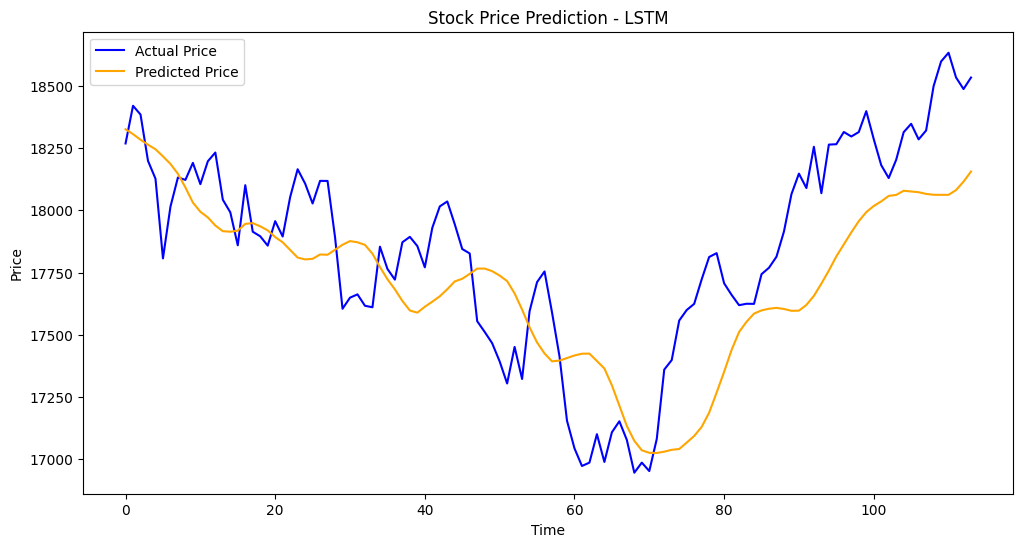

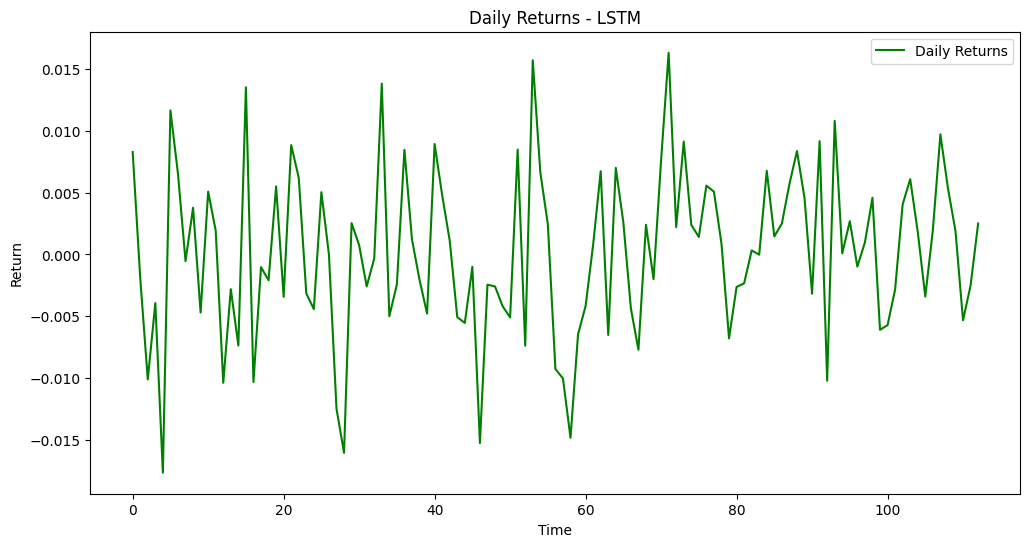

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from aro_optimiser2 import AROOptimizer

# Load the stock price data
data = pd.read_csv('ADANI.csv')
data = data.interpolate(method='linear')

# Extract the 'Close' column for prediction
closing_prices = data['Close'].values

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.9)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences and labels for training
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Reshape input data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model with more layers
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)




# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Scale the predictions back to the original range
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()


# Define time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform cross-validation
scores = []
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=16, verbose=0)
    val_predictions = model.predict(X_val_fold)
    val_predictions = scaler.inverse_transform(val_predictions)
    y_val_fold = scaler.inverse_transform(y_val_fold.reshape(-1, 1)).ravel()
    fold_score = mean_squared_error(y_val_fold, val_predictions)
    scores.append(fold_score)

# Calculate the mean score
mean_score = np.mean(scores)
print(mean_score)

# Calculate profits based on a simple trading strategy
buy_threshold = 0.02  # Percentage increase threshold to buy
sell_threshold = -0.01  # Percentage decrease threshold to sell
initial_investment = 10000  # Initial investment amount
shares = 0
cash = initial_investment

for i in range(len(test_predictions)):
    price_change = (y_test[i] - y_test[i-1]) / y_test[i-1]  # Percentage price change from the previous day
    
    if price_change > buy_threshold:
        shares_to_buy = cash / y_test[i]
        shares += shares_to_buy
        cash = 0
    elif price_change < sell_threshold:
        cash_to_sell = shares * y_test[i]
        cash += cash_to_sell
        shares = 0

final_balance = cash + (shares * y_test[-1])
profit = final_balance - initial_investment

# Calculate metrics
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
r2_score = r2_score(y_test, test_predictions)
# Calculate Daily Returns
daily_returns = np.diff(y_test) / y_test[:-1]

# Calculate Annualized Return
average_daily_return = np.mean(daily_returns)
trading_days_per_year = 252  # Assuming 252 trading days in a year
annualized_return = average_daily_return * trading_days_per_year

# Calculate Standard Deviation of Daily Returns
daily_returns_std = np.std(daily_returns)

# Calculate Sharpe Ratio
risk_free_rate = 0.0  # Assuming a risk-free rate of 0%
sharpe_ratio = (annualized_return - risk_free_rate) / daily_returns_std

# Calculate Maximum Drawdown
cumulative_returns = np.cumprod(1 + daily_returns)
peak = np.maximum.accumulate(cumulative_returns)
drawdown = (cumulative_returns - peak) / peak
maximum_drawdown = np.max(drawdown)

# Print the Results
print("Annualized Return:", annualized_return)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", maximum_drawdown)



# Print the metrics
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training MSE:", train_mse)
print("Testing MSE:", test_mse)
print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("R2 Score:", r2_score)
print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", maximum_drawdown)


print("Profit:", profit)

# Plot transactions for LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Price', color='blue')
plt.plot(test_predictions, label='Predicted Price', color='orange')
plt.title('Stock Price Prediction - LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate daily returns for LSTM
daily_returns_lstm = np.diff(y_test) / y_test[:-1]

# Plot returns for LSTM
plt.figure(figsize=(12, 6))
plt.plot(daily_returns_lstm, label='Daily Returns', color='green')
plt.title('Daily Returns - LSTM')
plt.xlabel('Time')
plt.ylabel('Return')
plt.legend()
plt.show()

